In [1]:
import mysqlconnect

In [2]:
import iql

In [3]:
import re

In [39]:
import pandas as pd
import numpy as np
from fbprophet import Prophet;
import matplotlib.pyplot as plt;
import matplotlib
matplotlib.style.use('ggplot')

In [6]:
%matplotlib inline

In [52]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [10]:
def traffic_data(country, channel, start, end):
    if channel=='all':
        _channel = ''
    else:
        _channel= "AND channel='{0}'".format(channel)
    qry_ga = ("SELECT activity_date, SUM(sessions) as sessions FROM t_ga_sampled_sessions_summarized "
              "WHERE country='{0}' {1} AND activity_date between '{2}' AND '{3}'"
              "GROUP BY activity_date".format(country, _channel, start, end))
    data = mysqlconnect.fetch_data(qry_ga, df=True)
    data.columns = ['ds', 'y']
    data['ds'] = pd.to_datetime(data['ds'])
    data['y'] = data['y'].apply(int)
    return data

In [11]:
traffic = traffic_data('US', 'all', '2013-01-01', '2016-12-31')

In [18]:
all_data = traffic_data('US', 'all', '2013-01-01', '2017-12-31')

In [12]:
#m = Prophet(growth='logistic')
m = Prophet(growth='linear')
m.fit(traffic);

In [13]:
future = m.make_future_dataframe(periods=1095)
#future['cap'] = 15000000.

In [14]:
forecast = m.predict(future)

In [15]:
forecast.head(2)

,ds,t,trend,seasonal_lower,seasonal_upper,trend_lower,trend_upper,yhat_lower,yhat_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,seasonal,yhat
0,2013-01-01,0.000000,3549974.166390,248145.642471,248145.642471,3549974.166390,3549974.166390,3228784.513151,4328142.982762,1029333.469711,1029333.469711,1029333.469711,-781187.82724,-781187.82724,-781187.82724,248145.642471,3798119.808861
1,2013-01-02,0.000685,3553344.875711,182791.878133,182791.878133,3553344.875711,3553344.875711,3145186.670580,4312861.175291,854765.922743,854765.922743,854765.922743,-671974.04461,-671974.04461,-671974.04461,182791.878133,3736136.753844


In [46]:
xf = pd.DataFrame(forecast.yhat.values, index=forecast.ds)

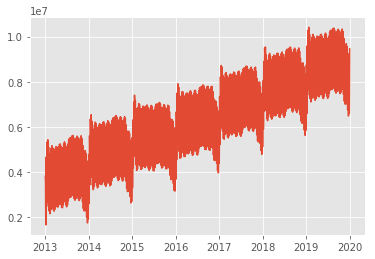

In [59]:
plt.plot(xf.index,xf[0])

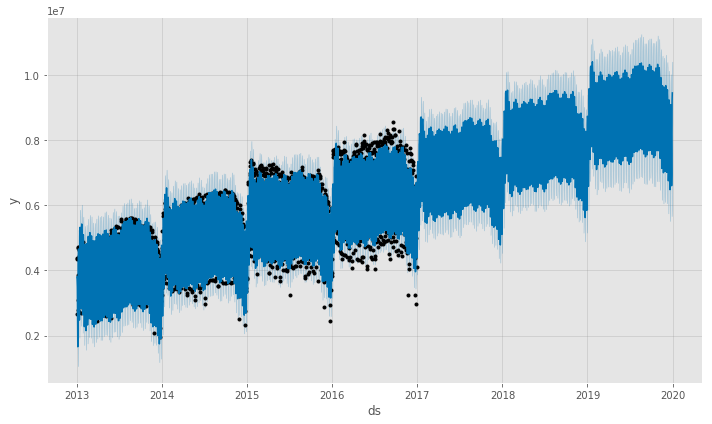

In [40]:
m.plot(forecast);

In [19]:
traffic_result = pd.merge(all_data, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], how='left', on=['ds'])

In [20]:
traffic_result['percent_error'] = (traffic_result.yhat - traffic_result.y)*100/traffic_result.y

In [21]:
def histogram(data, xmin=-25, xmax=25, ymin=0, ymax=0.15):
    plt.hist(data, 100, facecolor='blue', alpha=0.75, log=False,  normed=True, histtype='step')
    plt.xlabel(r'percent error', fontsize=20)
    plt.ylabel('probability density', fontsize=18)
    plt.axis([xmin, xmax, ymin, ymax])
    plt.grid(True)
    plt.show()

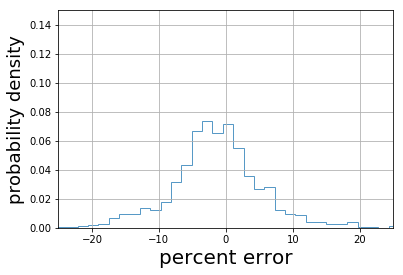

In [22]:
histogram(traffic_result['percent_error'])

In [23]:
forecast_ds = forecast.set_index(['ds'])

In [24]:
monthly_forecast = forecast_ds.resample('MS')['yhat'].sum()

In [25]:
all_data_ds = all_data.set_index(['ds'])

In [26]:
monthly_all_data = all_data_ds.resample('MS').sum()

In [27]:
def daily_forecast(country='US', channel='all', n_changepoints=25, holidays=None, 
             seasonality_scale=10.0, holidays_scale=10.0, changepoint_scale=0.05):
    traffic = traffic_data(country, channel, '2013-01-01', '2016-12-31')
    all_data = traffic_data(country, channel, '2013-01-01', '2017-12-31')
    m = Prophet(n_changepoints=n_changepoints, holidays=None, 
                seasonality_prior_scale=seasonality_scale, holidays_prior_scale=holidays_scale, 
                changepoint_prior_scale=changepoint_scale)
    m.fit(traffic);
    future = m.make_future_dataframe(periods=365)
    forecast = m.predict(future)
    result = pd.merge(all_data, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], how='left', on=['ds'])
    result['percent_error'] = (result.yhat - result.y)*100/result.y

    monthly_forecast = monthly(forecast, 'yhat')
    monthly_real_data = monthly(all_data, 'y') 
    real = monthly_real_data[-4:-1]
    prediction = monthly_forecast[-12:-9]
    print real
    print prediction
    print (prediction-real)/real
    return result, forecast

In [29]:
_, forec = daily_forecast('US', 'all')

NameError: global name 'monthly' is not defined

In [83]:
def to_csv(data, country, label):
    tmp = data[data.ds>='2017-01-01']
    tmp = tmp[['ds', 'yhat']]
    tmp.columns = ['date', 'sessions']
    tmp.set_index(['date'], inplace=True)
    tmp.to_csv('{0}_{1}.csv'.format(country.lower(), label))

In [88]:
to_csv(forec, 'ca', 'seo')

In [20]:
def monthly(df, column_name):
    m_df = df.set_index(['ds'])
    m_df = m_df.resample('MS')[column_name].sum()
    return m_df

def optimize(country='US', channel='all', cap=40000000, growth='linear', n_changepoints=25, holidays=None, 
             seasonality_scale=10.0, holidays_scale=10.0, changepoint_scale=0.05):
    traffic = traffic_data(country, channel, '2013-01-01', '2017-02-31')
    all_data = traffic_data(country, channel, '2013-01-01', '2017-12-31')
    #traffic['cap'] = cap
    m = Prophet(growth=growth, n_changepoints=n_changepoints, holidays=None, 
                seasonality_prior_scale=seasonality_scale, holidays_prior_scale=holidays_scale, 
                changepoint_prior_scale=changepoint_scale)
    m.fit(traffic);
    future = m.make_future_dataframe(periods=365)
    #future['cap'] = cap
    forecast = m.predict(future)
    result = pd.merge(all_data, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], how='left', on=['ds'])
    result['percent_error'] = (result.yhat - result.y)*100/result.y
    histogram(result['percent_error'])
    #check monthly
    monthly_forecast = monthly(forecast, 'yhat')
    monthly_real_data = monthly(all_data, 'y') 
    real = monthly_real_data[-4:-1]
    prediction = monthly_forecast[-12:-9]
    print real
    print prediction
    print (prediction-real)/real
    #m.plot_components(forecast);
    m.plot(forecast);

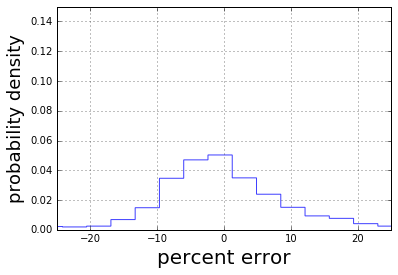

ds
2017-01-01    2557788
2017-02-01    2275562
2017-03-01    2608239
Freq: MS, Name: y, dtype: int64
ds
2017-03-01    2.450321e+06
2017-04-01    2.638262e+06
2017-05-01    2.836637e+06
Freq: MS, Name: yhat, dtype: float64
ds
2017-01-01         NaN
2017-02-01         NaN
2017-03-01   -0.060546
2017-04-01         NaN
2017-05-01         NaN
Freq: MS, dtype: float64


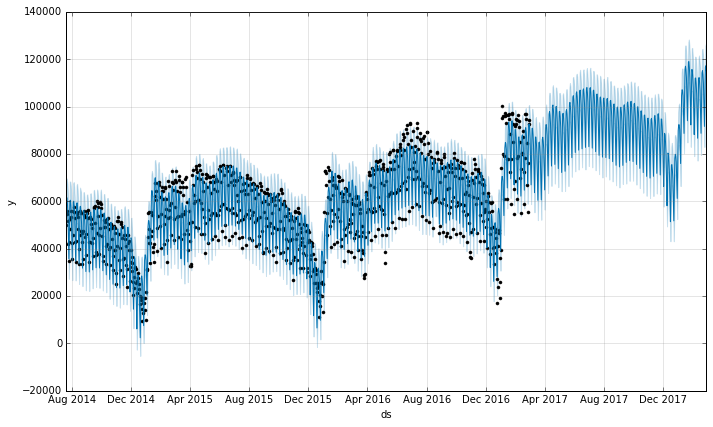

In [21]:
optimize('PH', channel='all', cap=1000000, growth='linear')

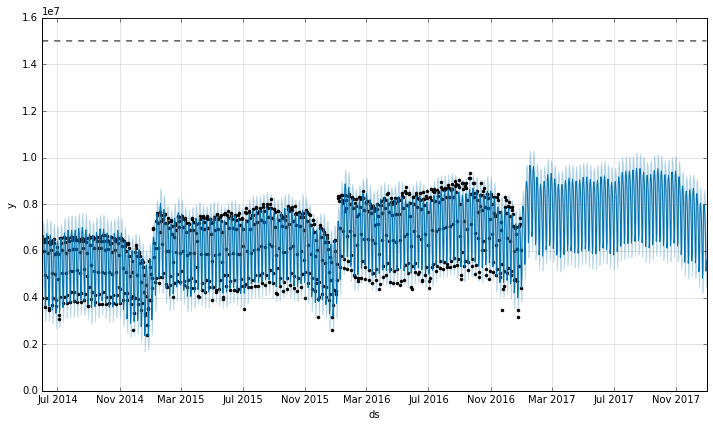

In [24]:
m.plot(forecast);

In [13]:
l = Prophet(growth='linear')
l.fit(traffic);

In [14]:
future_l = l.make_future_dataframe(periods=365)

In [15]:
forecast_l = l.predict(future_l)

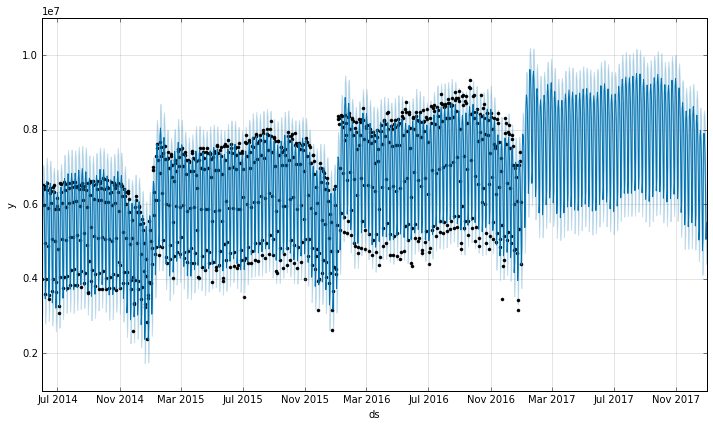

In [16]:
l.plot(forecast_l);

In [18]:
#m.plot(forecast);
#m.plot_components(forecast);
l.plot_yearly(forecast_l)

AttributeError: 'Prophet' object has no attribute 'plot_yearly'

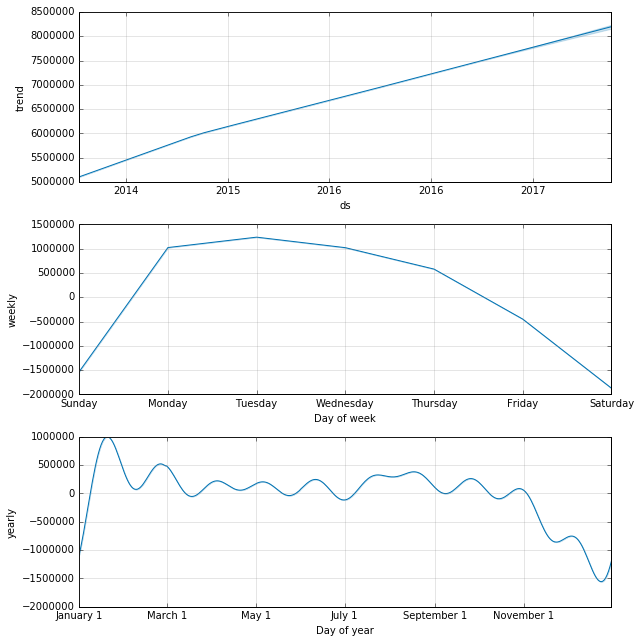

In [28]:
l.plot_components(forecast_l);

In [24]:
traffic_real = traffic_data('JP', 'all', '2013-01-01', '2017-12-31')

In [31]:
#traffic_real.plot()

In [37]:
n = Prophet(mcmc_samples=500)
n.fit(traffic_real);

In [38]:
future_real = n.make_future_dataframe(periods=365)

In [40]:
forecast_real = n.predict(future)

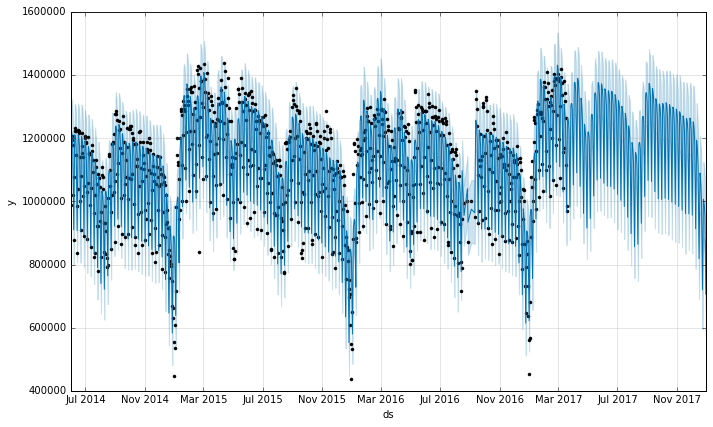

In [41]:
n.plot(forecast_real);

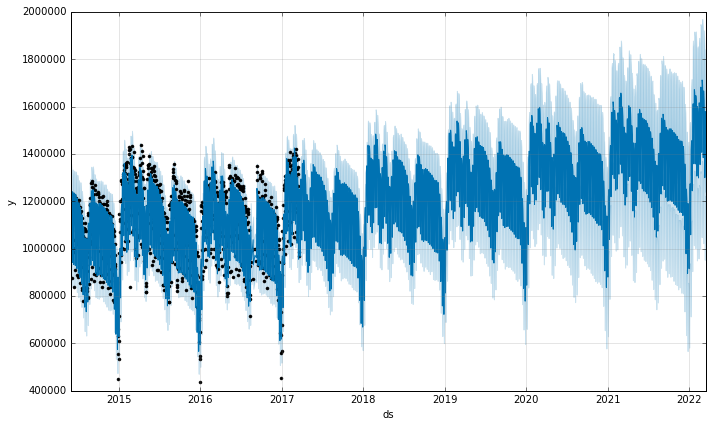

In [36]:
traffic_real['cap'] = 2000000.
o = Prophet(growth='logistic')
o.fit(traffic_real)
o_future = o.make_future_dataframe(periods=1826)
o_future['cap'] = 2000000.
fcst = o.predict(o_future)
o.plot(fcst);

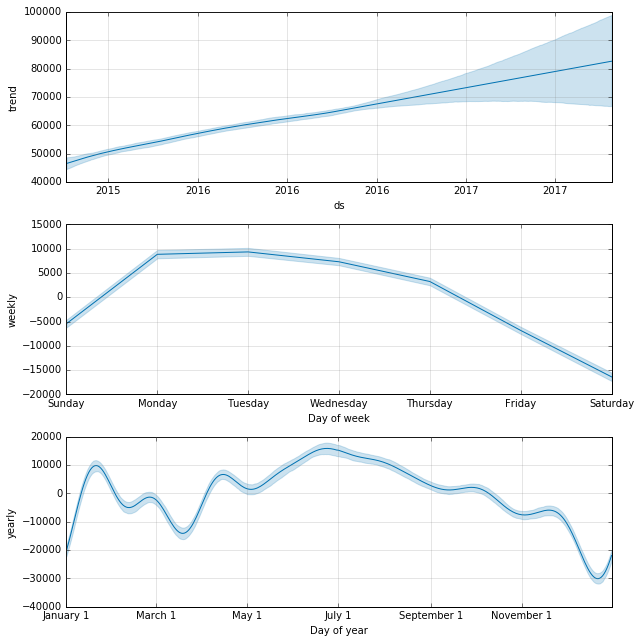

In [53]:
m.plot_components(forecast);

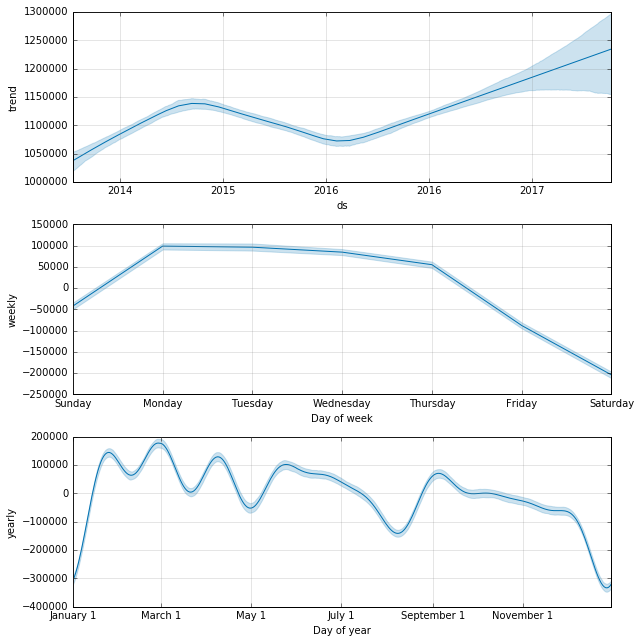

In [42]:
n.plot_components(forecast_real);